# Initial MLB Trade Predictor EDA

The idea for my product is a tool that predicts a player's likelihood to be traded in the coming offseason + season.

*Alternatively, perhaps it would be equally useful (or more useful) to predict it on a daily basis; however, this would require that I find signal of ~50 players traded in a span of ~100,000 data points, a signal of ~0.05%. I don't think this is as doable.*

For predictor variables, I expect to use:

* Player's stats from the previous season
* Player's salary (and/or portion of team's total salary)
* Player's age
* Team's record the past X seasons (maybe X is 3-5?)
* Team's total salary commitment

Some other features that might be helpful (but very possibly not):

* Population of team's immediate area (proxy for attendance)
* Team annual/average attendance for home games
* Appearance in "likely to be traded" articles or lists
* Appearance in "Team X should trade for player Y" articles

# Alternative idea: Predict free agent locations

In another alternative, every year there are ~100-200 major league free agents every offseason (doesn't count players from other leagues). Using similar metrics on statistics from previous year(s), age, team payrolls (previous couple years?), and position....could we predict where free agents would end up or for how much of a contract? Specifically, predict one of:

* Team to sign him
* How many years
* How much total money
* How much AAV

Reasons this is better:

* Free agents only happen in the offseason; very defined time
* Pool of free agents is a small, defined group of ~100-200 players
* A fair number of people write columns about who will go where
* Might be a lower bar for success; random would get ~1/30 (~3.3%) correct, versus beating the ~95% for 

Reasons this is worse:

* Not as much data to work with; rather than ~900 trade candidates, there's like ~200 

In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup

## Task 1: Pull down leaderboard data:

Perhaps I'll pull down leaderboard data from Fangraphs (.csv). The link to the leaderboard itself is:

http://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=2017&month=0&season1=2017&ind=0

That also requires clicking to download, and the DOWNLOAD button includes this URL info:

"javascript:__doPostBack('LeaderBoard1$cmdCSV','')"

Alternatively, there's the Lahman Database, which aggregates these data all the way back to 1871 and has a .CSV link here:

http://seanlahman.com/files/database/baseballdatabank-2017.1.zip

It also has a SQL link here:

http://seanlahman.com/files/database/lahman2016-sql.zip

There's also a GitHub version...

### First let's try Github version...I've cloned it locally

In [2]:
all_players = pd.read_csv("/home/matt/Github/baseballdatabank/core/Batting.csv")
all_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104324 entries, 0 to 104323
Data columns (total 22 columns):
playerID    104324 non-null object
yearID      104324 non-null int64
stint       104324 non-null int64
teamID      104324 non-null object
lgID        103586 non-null object
G           104324 non-null int64
AB          104324 non-null int64
R           104324 non-null int64
H           104324 non-null int64
2B          104324 non-null int64
3B          104324 non-null int64
HR          104324 non-null int64
RBI         103568 non-null float64
SB          101956 non-null float64
CS          80832 non-null float64
BB          104324 non-null int64
SO          97974 non-null float64
IBB         67722 non-null float64
HBP         101507 non-null float64
SH          98255 non-null float64
SF          68259 non-null float64
GIDP        78921 non-null float64
dtypes: float64(9), int64(10), object(3)
memory usage: 17.5+ MB


In [3]:
all_players.tail()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
104319,zimmejo02,2017,1,DET,AL,29,6,0,1,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
104320,zimmery01,2017,1,WAS,NL,144,524,90,159,33,...,108.0,1.0,0.0,44,126.0,1.0,3.0,0.0,5.0,16.0
104321,zobribe01,2017,1,CHN,NL,128,435,58,101,20,...,50.0,2.0,2.0,54,71.0,2.0,2.0,2.0,3.0,13.0
104322,zuninmi01,2017,1,SEA,AL,124,387,52,97,25,...,64.0,1.0,0.0,39,160.0,0.0,8.0,0.0,1.0,8.0
104323,zychto01,2017,1,SEA,AL,45,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Load the Teams csv file
all_teams = pd.read_csv("/home/matt/Github/baseballdatabank/core/Teams.csv")
all_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2865 entries, 0 to 2864
Data columns (total 48 columns):
yearID            2865 non-null int64
lgID              2815 non-null object
teamID            2865 non-null object
franchID          2865 non-null object
divID             1348 non-null object
Rank              2865 non-null int64
G                 2865 non-null int64
Ghome             2466 non-null float64
W                 2865 non-null int64
L                 2865 non-null int64
DivWin            1320 non-null object
WCWin             684 non-null object
LgWin             2837 non-null object
WSWin             2508 non-null object
R                 2865 non-null int64
AB                2865 non-null int64
H                 2865 non-null int64
2B                2865 non-null int64
3B                2865 non-null int64
HR                2865 non-null int64
BB                2864 non-null float64
SO                2745 non-null float64
SB                2739 non-null float64
CS  

In [5]:
# Look at the last couple records to get an idea
all_teams.tail()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
2860,2017,NL,SLN,STL,C,3,162,81.0,83,79,...,164,0.984,St. Louis Cardinals,Busch Stadium III,3447937.0,98,98,STL,SLN,SLN
2861,2017,AL,TBA,TBD,E,3,162,81.0,80,82,...,129,0.983,Tampa Bay Rays,Tropicana Field,1253619.0,94,94,TBR,TBA,TBA
2862,2017,AL,TEX,TEX,W,4,162,81.0,78,84,...,173,0.982,Texas Rangers,Rangers Ballpark in Arlington,2507760.0,107,107,TEX,TEX,TEX
2863,2017,AL,TOR,TOR,E,4,162,81.0,76,86,...,145,0.985,Toronto Blue Jays,Rogers Centre,3203886.0,105,105,TOR,TOR,TOR
2864,2017,NL,WAS,WSN,E,1,162,81.0,97,65,...,139,0.985,Washington Nationals,Nationals Park,2524980.0,103,102,WSN,MON,WAS


In [6]:
# Filter the teams data to only 1998-2017
all_teams = all_teams[all_teams.yearID >= 1998]
all_teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
2265,1998,AL,ANA,ANA,W,2,162,81.0,85,77,...,146,0.983,Anaheim Angels,Edison International Field,2519280.0,102,102,ANA,ANA,ANA
2266,1998,NL,ARI,ARI,W,5,162,81.0,65,97,...,125,0.984,Arizona Diamondbacks,Bank One Ballpark,3610290.0,100,99,ARI,ARI,ARI
2267,1998,NL,ATL,ATL,E,1,162,81.0,106,56,...,139,0.985,Atlanta Braves,Turner Field,3360860.0,100,98,ATL,ATL,ATL
2268,1998,AL,BAL,BAL,E,4,162,81.0,79,83,...,144,0.987,Baltimore Orioles,Oriole Park at Camden Yards,3684650.0,98,97,BAL,BAL,BAL
2269,1998,AL,BOS,BOS,E,2,162,81.0,92,70,...,128,0.983,Boston Red Sox,Fenway Park II,2314704.0,102,101,BOS,BOS,BOS


We should also read the "Batting", "Pitching", "Salaries" and "People" data into our dataframe format. We'll also grab post season stats as well

In [7]:
# Load the Teams csv file
all_batting = pd.read_csv("../baseballdatabank/core/Batting.csv")
all_pitching = pd.read_csv("../baseballdatabank/core/Pitching.csv")
all_salary = pd.read_csv("../baseballdatabank/core/Salaries.csv")
all_master = pd.read_csv("../baseballdatabank/core/People.csv")
all_batting_post = pd.read_csv("../baseballdatabank/core/BattingPost.csv")
all_pitching_post = pd.read_csv("../baseballdatabank/core/PitchingPost.csv")

# Look at the columns
print(all_batting.columns)
print(all_pitching.columns)
print(all_salary.columns)
print(all_batting_post.columns)
print(all_pitching_post.columns)
print(all_master.columns)

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')
Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')
Index(['yearID', 'teamID', 'lgID', 'playerID', 'salary'], dtype='object')
Index(['yearID', 'round', 'playerID', 'teamID', 'lgID', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP'],
      dtype='object')
Index(['playerID', 'yearID', 'round', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')
Index(['playerID', 'birthYea

In [8]:
# Print batting data shape first
print(all_batting.shape)

# We'll screen out years without player IDs in the first 5 DFs
all_batting, all_pitching, all_salary, all_batting_post, all_pitching_post = [
df[df.yearID >= 1998] for df in [all_batting, all_pitching, all_salary, all_batting_post, all_pitching_post]]

# Take a look at the batting info
all_batting.info()
print(all_batting.shape)
print(all_batting.head())

(104324, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27681 entries, 76643 to 104323
Data columns (total 22 columns):
playerID    27681 non-null object
yearID      27681 non-null int64
stint       27681 non-null int64
teamID      27681 non-null object
lgID        27681 non-null object
G           27681 non-null int64
AB          27681 non-null int64
R           27681 non-null int64
H           27681 non-null int64
2B          27681 non-null int64
3B          27681 non-null int64
HR          27681 non-null int64
RBI         27681 non-null float64
SB          27681 non-null float64
CS          27681 non-null float64
BB          27681 non-null int64
SO          27681 non-null float64
IBB         27681 non-null float64
HBP         27681 non-null float64
SH          27681 non-null float64
SF          27681 non-null float64
GIDP        27681 non-null float64
dtypes: float64(9), int64(10), object(3)
memory usage: 4.9+ MB
(27681, 22)
        playerID  yearID  stint teamID lgID   G   A

Just looking at the batting data, we're going to have to aggregate some of these for players who had a 2nd stint on a team. We should definitely do a group by on the year + playerID and aggregate by SUM. Perhaps we can also:

1. Add a variable called "traded"
2. For players with max(stint) > 1, make "traded" True

In [9]:
# Then let's aggregate the player IDs from those
batting_players = all_batting.playerID.values
pitching_players = all_pitching.playerID.values
print(len(np.union1d(batting_players, pitching_players)))

salary_players = all_salary.playerID.values
batting_post_players = all_batting_post.playerID.values
pitching_post_players = all_pitching_post.playerID.values

print(len(np.union1d(np.union1d(np.union1d(batting_players,
                                           pitching_players),
                                salary_players),
                     np.union1d(batting_post_players,
                                pitching_post_players))))



# Finally, screen out the data from the People table

5462
5484


In [10]:
all_master.columns

Index(['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry',
       'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame',
       'retroID', 'bbrefID'],
      dtype='object')

## Task 2: Compile Payroll Data

Note that there's no payroll data right now...there's payroll data per year here:

http://www.thebaseballcube.com/extras/payrolls/

There's also this site, which looks :

http://www.stevetheump.com/Payrolls.htm

And there's some other sites...let's see what we can do with some BeautifulSoup

In [11]:
# Get the first site
url = "http://www.thebaseballcube.com/extras/payrolls/"

results = requests.get(url).text

payroll_soup = BeautifulSoup(results, 'html.parser')
just_table = payroll_soup.find_all('table')[1]

After some exploration of how to access the data, I'm going to do it using the table:

In [12]:
# A header row and a row for each team
len(just_table.contents)

31

In [13]:
# Get all the data on payroll (1998-2017) for the Diamondbacks
post_2002 = [line.text for line in just_table.contents[1].find_all('a')]
pre_2003 = [line.text.split(' - ')[1] for line in just_table.contents[1].find_all('td')[-1].find_all('option')]
all_dbacks = (post_2002 + pre_2003)
all_dbacks.reverse() # Sort so now its 1998->2017, not the other way around
print(all_dbacks)


['29.16', '70.37', '77.88', '85.25', '102.82', '80.64', '69.78', '62.33', '59.68', '52.07', '66.20', '73.52', '60.72', '53.64', '74.28', '90.16', '112.69', '65.77', '98.66', '90.73']


In [14]:
# Get data for all teams
team_dict = {}
for entry in just_table.contents[1:]:
    team = entry.find_all('td')[0].text
    post_2002 = [float(line.text) for line in entry.find_all('a')]
    pre_2003 = [float(line.text.split(' - ')[1]) for line in entry.find_all('td')[-1].find_all('option')]
    
    # Shorten the pre-2003 to just 5 years, back to 1998
    
    all_salaries = post_2002 + pre_2003[0:5]
    all_salaries.reverse()
    team_dict[team] = all_salaries

# Make it a dataframe
payroll_df = pd.DataFrame(team_dict)
payroll_df['Year'] = pd.to_datetime(list(range(1998, 2018)), format = '%Y')
payroll_df.set_index('Year', inplace=True)
payroll_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 1998-01-01 to 2017-01-01
Data columns (total 30 columns):
Arizona Diamondbacks     20 non-null float64
Atlanta Braves           20 non-null float64
Baltimore Orioles        20 non-null float64
Boston Red Sox           20 non-null float64
Chicago Cubs             20 non-null float64
Chicago White Sox        20 non-null float64
Cincinnati Reds          20 non-null float64
Cleveland Indians        20 non-null float64
Colorado Rockies         20 non-null float64
Detroit Tigers           20 non-null float64
Houston Astros           20 non-null float64
Kansas City Royals       20 non-null float64
Los Angeles Angels       20 non-null float64
Los Angeles Dodgers      20 non-null float64
Miami Marlins            20 non-null float64
Milwaukee Brewers        20 non-null float64
Minnesota Twins          20 non-null float64
New York Mets            20 non-null float64
New York Yankees         20 non-null float64
Oakland Athletics     

In [15]:
# Get the team name titles (column names)
team_names = [team.find_all('td')[0].text for team in just_table.contents][1:]
team_names

['Arizona Diamondbacks',
 'Atlanta Braves',
 'Baltimore Orioles',
 'Boston Red Sox',
 'Chicago Cubs',
 'Chicago White Sox',
 'Cincinnati Reds',
 'Cleveland Indians',
 'Colorado Rockies',
 'Detroit Tigers',
 'Houston Astros',
 'Kansas City Royals',
 'Los Angeles Angels',
 'Los Angeles Dodgers',
 'Miami Marlins',
 'Milwaukee Brewers',
 'Minnesota Twins',
 'New York Mets',
 'New York Yankees',
 'Oakland Athletics',
 'Philadelphia Phillies',
 'Pittsburgh Pirates',
 'San Diego Padres',
 'San Francisco Giants',
 'Seattle Mariners',
 'St. Louis Cardinals',
 'Tampa Bay Rays',
 'Texas Rangers',
 'Toronto Blue Jays',
 'Washington Nationals']

## Task 3: Get Free Agent Data

We also need the free agent data itself; one source is Baseball Reference:

Example (2016): https://www.baseball-reference.com/leagues/MLB/2016-free-agents.shtml#fa_signings::none

Probably easiest to just scrape the years I want; could do it fairly quickly

In [16]:
# 2016 Data Scraping

# Step 1: Isolate the table
url = "https://www.baseball-reference.com/leagues/MLB/2016-free-agents.shtml#fa_signings::none"

results = requests.get(url).text

free_agent_soup = BeautifulSoup(results, 'html.parser')
fa_table = free_agent_soup.find(id = 'all_fa_signings').find(id = 'fa_signings').find('tbody')

In [42]:
# Make it into a function that takes in a year and builds a data frame
def compileFAsForYear(year, fa_table):
    
    # Build the URL given the year
    url = "https://www.baseball-reference.com/leagues/MLB/{}-free-agents.shtml#fa_signings::none".format(year)
    
    # Get the full page and then narrow down to the table
    results = requests.get(url).text
    free_agent_soup = BeautifulSoup(results, 'html.parser')
    fa_table = free_agent_soup.find(id = 'all_fa_signings').find(id = 'fa_signings').find('tbody')
    
    # Compile the players and destinations as list comprehensions
    fa_players = [player_info.find('td', {"data-stat":"player"}).text.strip() for player_info in fa_table.find_all('tr')]
    fa_destinations = [player_info.find('td',{"data-stat":"to_team_ID"}).text.strip() for player_info in fa_table.find_all('tr')]
    fa_origins = [player_info.find('td', {"data-stat":"from_team_ID"}).text.strip() for player_info in fa_table.find_all('tr')]
    fa_war = [player_info.find('td', {"data-stat":"WAR"}).text.strip() for player_info in fa_table.find_all('tr')]
    
    # Make a data frame from the lists
    fa_dict = {"Full_Name" : fa_players,
               "Destination" : fa_destinations,
               "Origin" : fa_origins,
               "WAR_3" : fa_war
          }

    fa_df = pd.DataFrame(fa_dict)
    
    # Split the "Full Name" into First and Last
    ## Note: This also gets rid of the annoying 'HOF' tag that comes third
    fa_df['nameFirst'] = fa_df.Full_Name.str.split(" ").str.get(0)
    fa_df['nameLast'] = fa_df.Full_Name.str.split(" ").str.get(1)
    
    # Broadcast the year, which is for the data + 1
    fa_df['Year'] = pd.to_datetime(year, format = '%Y')
    
    # Convert WAR to a numeric and fill missing values with "0"
    fa_df['WAR_3'] = pd.to_numeric(fa_df['WAR_3'], errors='coerce')
    fa_df['WAR_3'] = fa_df['WAR_3'].fillna(0)
    
    # Convert altered Destination/Origin 
    dest_change = {'Anaheim Angels': 'Los Angeles Angels of Anaheim', 
                   'Tampa Bay Devil Rays' : 'Tampa Bay Rays',
                   'Montreal Expos' : 'Washington Nationals', 
                   'Florida Marlins' : 'Miami Marlins'
                  }
    
    origin_change = {'ANA': 'LAA', 'TBD':'TBR', 'MON':'WSN', 'FLA':'MIA'}

    fa_df['Destination'] = fa_df['Destination'].replace(dest_change)
    fa_df['Origin'] = fa_df['Origin'].replace(origin_change)
    
    return fa_df

In [43]:
test = compileFAsForYear(1998, fa_table)
test.head()

,Destination,Full_Name,Origin,WAR_3,nameFirst,nameLast,Year
0,Seattle Mariners,Allen Watson,LAA,1.9,Allen,Watson,1998-01-01
1,Pittsburgh Pirates,Frank Castillo,DET,-2.5,Frank,Castillo,1998-01-01
2,Los Angeles Dodgers,Robinson Checo,BOS,0.1,Robinson,Checo,1998-01-01
3,Toronto Blue Jays,Pat Kelly,STL,-0.2,Pat,Kelly,1998-01-01
4,Detroit Tigers,Walt McKeel,BOS,-0.1,Walt,McKeel,1998-01-01


In [69]:
print(test.Destination.value_counts())

Kansas City Royals               19
Baltimore Orioles                14
Los Angeles Dodgers              14
Pittsburgh Pirates               13
Philadelphia Phillies            12
Cincinnati Reds                  12
Tampa Bay Rays                   12
Colorado Rockies                 12
Los Angeles Angels of Anaheim    12
Boston Red Sox                   11
Toronto Blue Jays                10
San Diego Padres                  9
Cleveland Indians                 9
Texas Rangers                     9
Arizona Diamondbacks              9
Detroit Tigers                    9
Seattle Mariners                  9
Oakland Athletics                 8
New York Yankees                  8
Chicago Cubs                      8
New York Mets                     8
St. Louis Cardinals               8
Houston Astros                    7
Milwaukee Brewers                 6
San Francisco Giants              5
Atlanta Braves                    5
Washington Nationals              4
Minnesota Twins             

In [46]:
# Create a list of years and use it to create a list of data frames
all_years = list(range(1998,2017))

# This takes about 15-30 seconds
all_fa_dfs = [compileFAsForYear(year, fa_table) for year in all_years]

In [47]:
# Crunch those data frames into one data frame using pd.concat
full_fa_outcomes = pd.concat(all_fa_dfs)
full_fa_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7549 entries, 0 to 392
Data columns (total 7 columns):
Destination    7549 non-null object
Full_Name      7549 non-null object
Origin         7549 non-null object
WAR_3          7549 non-null float64
nameFirst      7549 non-null object
nameLast       7549 non-null object
Year           7549 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 471.8+ KB


**Note: there's an empty string for Destination here**

In [53]:
full_fa_outcomes.Destination.unique()

array(['Seattle Mariners', 'Pittsburgh Pirates', 'Los Angeles Dodgers',
       'Toronto Blue Jays', 'Detroit Tigers', 'Miami Marlins',
       'Cleveland Indians', 'Washington Nationals', 'New York Yankees',
       'New York Mets', 'Philadelphia Phillies', 'Cincinnati Reds',
       'Texas Rangers', 'Boston Red Sox', 'Kansas City Royals',
       'Atlanta Braves', 'Oakland Athletics', 'St. Louis Cardinals',
       'Colorado Rockies', 'Baltimore Orioles', 'Tampa Bay Rays',
       'Milwaukee Brewers', 'Los Angeles Angels of Anaheim',
       'Chicago White Sox', 'Houston Astros', 'San Francisco Giants',
       'Minnesota Twins', 'San Diego Padres', 'Arizona Diamondbacks',
       'Chicago Cubs', ''], dtype=object)

In [70]:
full_fa_outcomes[full_fa_outcomes.Destination == '']

,Destination,Full_Name,Origin,WAR_3,nameFirst,nameLast,Year
21,,Andy Fox,TEX,-2.0,Andy,Fox,2004-01-01
48,,Carlos Baerga,ARI,0.5,Carlos,Baerga,2004-01-01
49,,Luke Allen,PIT,-0.1,Luke,Allen,2004-01-01
56,,Hector Ortiz,COL,0.1,Hector,Ortiz,2004-01-01
61,,Lou Merloni,CLE,2.3,Lou,Merloni,2004-01-01
118,,Esteban Loaiza,NYY,7.1,Esteban,Loaiza,2004-01-01
122,,Antonio Osuna,SDP,2.3,Antonio,Osuna,2004-01-01
129,,Keith Osik,TBR,0.2,Keith,Osik,2004-01-01
154,,Orlando Cabrera,BOS,6.8,Orlando,Cabrera,2004-01-01
164,,Corey Lee,LAA,0.0,Corey,Lee,2004-01-01


*Going forward, we may have to drop these 35 cases from the data set*

## Task 4: Acquire "Need" Data (??)

I would like to quantify a team's "need" at a position based on their previous year's level of production. This would be equivalent to:

1) Find the team's position-by-position WAR for a given season...

Here's the 2017 batting stats URL for the Braves at catcher:

http://www.fangraphs.com/leaders.aspx?pos=c&stats=bat&lg=all&qual=0&type=8&season=2017&month=0&season1=2017&ind=0&team=0,ts&rost=0&age=0&filter=&players=0

The "get the CSV" part is some javascript link: javascript:__doPostBack('LeaderBoard1$cmdCSV','')

**This is much messier...I can think about adding this later!!**

### New Plan: Avoid Selenium

The plan is this:

* For 1998-2016, feed in the URL for the team stats for each position, one by one, like this (Catcher for 1998):

http://www.fangraphs.com/leaders.aspx?pos=c&stats=bat&lg=all&qual=0&type=8&season=1998&month=0&season1=1998&ind=0&team=0,ts&rost=0&age=0&filter=&players=0

* Scrape the data for that year, in particular the WAR for each team
* Broadcast the year and position to each data frame as I go along
* Concatenate the data frames.....

    * Rows should be year/position combinations
    * Columns should be the team WAR values for those years

In [120]:
# Test space: 1998 catchers

url = "http://www.fangraphs.com/leaders.aspx?pos=c&stats=bat&lg=all&qual=0&type=8&season=1998&month=0&season1=1998&ind=0&team=0,ts&rost=0&age=0&filter=&players=0"

results = requests.get(url).text
team_war_soup = BeautifulSoup(results, 'html.parser')

stat_table = team_war_soup.find('table', {'class' : 'rgMasterTable'}).find('tbody').find_all('tr')


# Get the team name
test_list = [team_row.find('a').text for team_row in stat_table]
print(test_list)
# Get the WAR value
test_war = [float(team_row.find_all('td')[-1].text) for team_row in stat_table]
print(test_war)

['Rangers', 'Mets', 'Braves', 'Pirates', 'Yankees', 'Diamondbacks', 'Orioles', 'Astros', 'Red Sox', 'Dodgers', 'Blue Jays', 'Giants', 'Padres', 'Reds', 'Cardinals', 'Expos', 'Rockies', 'Royals', 'White Sox', 'Marlins', 'Tigers', 'Athletics', 'Mariners', 'Twins', 'Cubs', 'Angels', 'Brewers', 'Devil Rays', 'Indians', 'Phillies']
[6.8, 6.1, 5.7, 5.6, 3.8, 2.8, 2.5, 2.4, 2.3, 2.3, 1.9, 1.9, 1.8, 1.7, 1.3, 1.3, 1.1, 1.1, 1.0, 0.9, 0.8, 0.8, 0.7, 0.7, 0.6, -0.2, -0.2, -0.3, -0.4, -0.4]


In [148]:
# Create a function that does this for a given year and position
def getTeamPosWar(position, year):
    
    # Create the URL
    url = ("http://www.fangraphs.com/leaders.aspx?pos={}"
           "&stats=bat&lg=all&qual=0&type=8&season={}&month=0&season1={}"
           "&ind=0&team=0,ts&rost=0&age=0&filter=&players=0").format(position, year, year)

    # Open the page and grab the soup
    results = requests.get(url).text
    team_war_soup = BeautifulSoup(results, 'html.parser')
    
    # Turn the soup into just the table for convenience
    stat_table = team_war_soup.find('table', {'class' : 'rgMasterTable'}).find('tbody').find_all('tr')
    
    # Make a dictionary with team as key and WAR as value
    team_war_dict = {team_row.find('a').text : [float(team_row.find_all('td')[-1].text)] for team_row in stat_table}
    
    # Make the dictionary into a data frame (1 row), add year and position
    team_war_df = pd.DataFrame(team_war_dict)
    team_war_df['Position'] = position.upper()
    team_war_df['Year'] = pd.to_datetime(year, format = '%Y')
    
    # Catch any columns that aren't the right names and change them
    # Devil Rays --> Rays
    # Expos --> Nationals
    team_war_df = team_war_df.rename(columns={"Devil Rays": "Rays", 
                                              "Expos": "Nationals"}
                                    )
    
    return team_war_df


Grab all the data (all 9 x 19 sheets = 171 data frames); this takes ~ 3-5 min

In [158]:
positions = ['c', '1b', '2b', '3b', 'ss', 'lf', 'rf', 'cf', 'dh']

all_war_dfs = [getTeamPosWar(position, year) for position in positions for year in range(1998,2017)]

In [161]:
all_war_df = pd.concat(all_war_dfs)
all_war_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 0 to 0
Data columns (total 32 columns):
Angels          171 non-null float64
Astros          156 non-null float64
Athletics       171 non-null float64
Blue Jays       171 non-null float64
Braves          152 non-null float64
Brewers         155 non-null float64
Cardinals       152 non-null float64
Cubs            152 non-null float64
Diamondbacks    158 non-null float64
Dodgers         155 non-null float64
Giants          154 non-null float64
Indians         171 non-null float64
Mariners        171 non-null float64
Marlins         154 non-null float64
Mets            154 non-null float64
Nationals       154 non-null float64
Orioles         171 non-null float64
Padres          156 non-null float64
Phillies        154 non-null float64
Pirates         154 non-null float64
Position        171 non-null object
Rangers         171 non-null float64
Rays            171 non-null float64
Red Sox         171 non-null float64
Reds      

In [173]:
dodgers = all_war_df[['Dodgers', 'Position']].dropna()
dodgers.Position.value_counts()

3B    19
CF    19
1B    19
C     19
LF    19
RF    19
2B    19
SS    19
DH     3
Name: Position, dtype: int64

In [164]:
# Pickle the player data
import pickle

position_war = open("position_war.pickle", "wb")
pickle.dump(all_war_df, position_war)
position_war.close()

In [177]:
# Make a similar function for pitchers
def getTeamPitcherWar(year):
    '''Define the starter and reliever data separately, then get both and combine them'''
    
    # Create the URL
    starter_url = ("http://www.fangraphs.com/leaders.aspx?pos=all&stats=sta&lg=all&qual=0"
                   "&type=8&season={}&month=0&season1={}"
                   "&ind=0&team=0,ts&rost=0&age=0&filter=&players=0").format(year, year)
    
    reliever_url = ("http://www.fangraphs.com/leaders.aspx?pos=all&stats=rel&lg=all&qual=0"
                    "&type=8&season={}&month=0&season1={}"
                    "&ind=0&team=0,ts&rost=0&age=0&filter=&players=0").format(year, year)

    # Create another function that opens a given URL and fills in the correct position
    def getWARForRole(url, position):
    
        # Open the page and grab the soup
        results = requests.get(url).text
        team_war_soup = BeautifulSoup(results, 'html.parser')
    
        # Turn the soup into just the table for convenience
        stat_table = team_war_soup.find('table', {'class' : 'rgMasterTable'}).find('tbody').find_all('tr')
    
        # Make a dictionary with team as key and WAR as value
        role_war_dict = {team_row.find('a').text : [float(team_row.find_all('td')[-1].text)] for team_row in stat_table}
    
        # Make the dictionary into a data frame (1 row), add year and position
        role_war_df = pd.DataFrame(role_war_dict)
        role_war_df['Position'] = position.upper()
    
        return role_war_df
    
    # Use it to get the team pitcher WAR values for relievers and starters
    starter_df = getWARForRole(starter_url, 'sp')
    reliever_df = getWARForRole(reliever_url, 'rp')
    
    # Combine them and add the year
    all_pitching_war = pd.concat([starter_df, reliever_df])
    
    all_pitching_war['Year'] = pd.to_datetime(year, format = '%Y')
    
    # Catch any columns that aren't the right names and change them
    # Devil Rays --> Rays
    # Expos --> Nationals
    all_pitching_war = all_pitching_war.rename(columns={"Devil Rays": "Rays", 
                                                        "Expos": "Nationals"}
                                              )
    
    return all_pitching_war


Get all pitcher WAR data (full command takes ~1 minute)

In [178]:
blah = getTeamPitcherWar(1998)

In [179]:
blah.head()

,Angels,Astros,Athletics,Blue Jays,Braves,Brewers,Cardinals,Cubs,Rays,Diamondbacks,...,Red Sox,Reds,Rockies,Royals,Tigers,Twins,White Sox,Yankees,Position,Year
0,12.0,15.6,8.8,16.1,24.4,6.2,12.5,14.0,7.8,8.8,...,11.3,12.4,10.7,8.6,11.1,11.5,5.3,18.4,SP,1998-01-01
0,3.7,2.8,3.1,2.5,2.5,2.3,0.0,0.8,3.0,0.2,...,4.2,0.3,5.0,2.7,1.8,2.8,0.2,2.8,RP,1998-01-01


In [180]:
all_pitching_dfs = [getTeamPitcherWar(year) for year in range(1998,2017)]
all_pitching_team_war = pd.concat(all_pitching_dfs)

In [182]:
all_pitching_team_war.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 0
Data columns (total 32 columns):
Angels          38 non-null float64
Astros          38 non-null float64
Athletics       38 non-null float64
Blue Jays       38 non-null float64
Braves          38 non-null float64
Brewers         38 non-null float64
Cardinals       38 non-null float64
Cubs            38 non-null float64
Diamondbacks    38 non-null float64
Dodgers         38 non-null float64
Giants          38 non-null float64
Indians         38 non-null float64
Mariners        38 non-null float64
Marlins         38 non-null float64
Mets            38 non-null float64
Nationals       38 non-null float64
Orioles         38 non-null float64
Padres          38 non-null float64
Phillies        38 non-null float64
Pirates         38 non-null float64
Position        38 non-null object
Rangers         38 non-null float64
Rays            38 non-null float64
Red Sox         38 non-null float64
Reds            38 non-null float64

In [181]:
# Pickle the pitcher data
pitcher_war = open("pitcher_war.pickle", "wb")
pickle.dump(all_pitching_team_war, pitcher_war)
position_war.close()

Start from Selenium example and then add complexity

In [86]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By

# Alter the chrome profile
profile = webdriver.ChromeOptions()
profile.

In [84]:
# Create a url to work with
fangraphs_url = ("http://www.fangraphs.com/leaders.aspx" + 
                "?pos=all&stats=bat&lg=all&qual=y&type=8&season=2017&month=0&season1=2017&" +
                "ind=0&team=&rost=&age=&filter=&players=")

# Create a driver instance and navigate to the page, and confirm the title has 'Python'
driver = webdriver.Chrome()
driver.get(fangraphs_url)

# Find the "Export Data" Button
wait = WebDriverWait(driver, 10)
blah = wait.until(EC.element_to_be_clickable((By.LINK_TEXT, "Export Data")))
export_link = driver.find_element_by_id('LeaderBoard1_cmdCSV')
print(export_link.get_attribute('href'))

driver.close()

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=63.0.3239.132)
  (Driver info: chromedriver=2.35.528139 (47ead77cb35ad2a9a83248b292151462a66cd881),platform=Linux 4.10.0-42-generic x86_64)


In [ ]:
assert "Python" in driver.title

# Find an element named "q", clear any pre-populated text
elem = driver.find_element_by_name("q") # This is for a query
elem.clear()

# Fill the input field (search) with "pycon" and search 
elem.send_keys("pycon")
elem.send_keys(Keys.RETURN)

# Make sure results are found, then close the driver
assert "No results found." not in driver.page_source
driver.close()

## Task 5: EDA

I'm going to transpose the salary data and stick it together with teams and their info. Then I'm going to make a graph!

In [61]:
# Transpose the df
payroll_transpose = payroll_df.transpose()
payroll_transpose

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Arizona Diamondbacks,29.16,70.37,77.88,85.25,102.82,80.64,69.78,62.33,59.68,52.07,66.20,73.52,60.72,53.64,74.28,90.16,112.69,65.77,98.66,90.73
Atlanta Braves,59.54,75.07,82.73,91.94,93.47,106.24,90.18,86.46,90.16,87.29,102.37,96.73,84.42,87.00,83.31,89.29,110.90,89.62,84.82,137.34
Baltimore Orioles,70.41,70.82,83.14,74.28,60.49,73.88,51.62,73.91,72.59,93.17,67.20,67.10,81.61,85.30,81.43,91.79,107.41,118.86,147.94,161.68
Boston Red Sox,51.65,71.72,81.21,109.68,108.37,99.95,127.30,123.51,120.10,143.03,133.39,121.75,162.75,161.76,173.19,158.97,162.82,168.69,199.86,174.29
Chicago Cubs,49.38,55.37,62.13,64.52,75.69,79.87,90.56,87.03,94.42,99.67,118.35,134.81,146.86,125.05,88.20,104.15,89.01,117.16,167.44,170.09
Chicago White Sox,36.84,24.55,31.16,65.63,57.05,51.01,65.21,75.18,102.75,108.67,121.19,96.07,108.27,127.79,96.92,124.07,91.16,110.71,116.00,109.59
Cincinnati Reds,22.00,42.14,44.22,48.78,45.05,59.36,46.62,61.89,60.91,68.52,74.12,73.56,72.39,75.95,82.20,110.57,112.39,117.73,93.17,82.38
Cleveland Indians,59.03,73.85,76.51,92.66,78.91,45.58,34.32,41.50,56.03,61.67,78.97,81.58,61.20,49.19,78.43,82.52,82.53,87.75,98.01,115.99
Colorado Rockies,47.43,54.39,64.13,71.54,56.85,67.18,65.45,48.16,41.23,54.04,68.66,75.20,84.23,88.15,78.07,75.45,95.83,98.26,113.24,101.51
Detroit Tigers,22.63,34.96,61.74,49.36,55.05,49.17,46.83,69.09,82.61,94.80,137.69,115.09,122.86,105.70,132.30,149.05,162.23,172.79,199.53,180.25


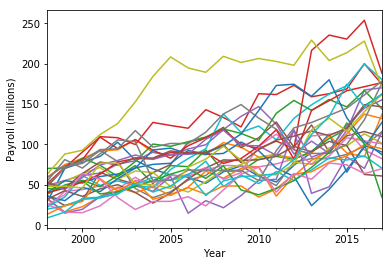

In [82]:
# Make a plot of teams with their salaries
plt.figure()
payroll_df.plot(legend=False)
plt.ylabel('Payroll (millions)')
plt.savefig('payroll_plot.png')
plt.show()

What if we took a look at one team's wins + salaries per year and used that to make a plot?

In [97]:
# Extract "Seattle Mariners" data
seattle_teams = all_teams[all_teams.teamID == 'SEA']
seattle_payroll 
seattle_teams['Payroll'] = payroll_df['Seattle Mariners'].values
seattle_teams['Year'] = pd.to_datetime(seattle_teams['yearID'], format = '%Y')
seattle_teams.head()

/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/matt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,Payroll,Year
2289,1998,AL,SEA,SEA,W,3,161,81.0,76,85,...,Seattle Mariners,Kingdome,2651511.0,99,99,SEA,SEA,SEA,52.03,1998-01-01
2319,1999,AL,SEA,SEA,W,3,162,81.0,79,83,...,Seattle Mariners,Kingdome / Safeco Field,2916346.0,102,103,SEA,SEA,SEA,44.37,1999-01-01
2349,2000,AL,SEA,SEA,W,2,162,81.0,91,71,...,Seattle Mariners,Safeco Field,2914624.0,95,93,SEA,SEA,SEA,59.22,2000-01-01
2379,2001,AL,SEA,SEA,W,1,162,81.0,116,46,...,Seattle Mariners,Safeco Field,3507326.0,94,93,SEA,SEA,SEA,74.72,2001-01-01
2409,2002,AL,SEA,SEA,W,3,162,81.0,93,69,...,Seattle Mariners,Safeco Field,3542938.0,97,95,SEA,SEA,SEA,80.28,2002-01-01


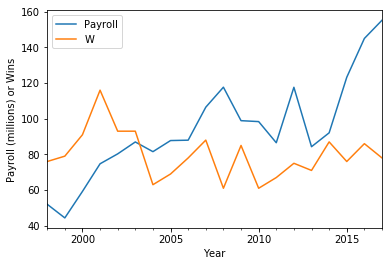

In [106]:
plt.figure()
seattle_teams[['Year', 'Payroll', 'W']].plot(x = 'Year')
plt.xlabel('Year')
plt.ylabel('Payroll (millions) or Wins')
plt.savefig('seattle_plot.png')
plt.show()

In [95]:
seattle_payroll.values

array([  52.03,   44.37,   59.22,   74.72,   80.28,   86.96,   81.52,
         87.75,   87.96,  106.46,  117.67,   98.9 ,   98.38,   86.52,
        117.62,   84.3 ,   92.08,  123.23,  145.  ,  155.21])

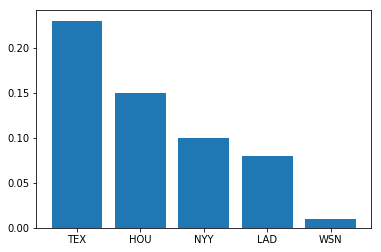

In [126]:
plt.figure()
plt.bar(list(range(5)),[0.23, 0.15, 0.10, 0.08, 0.01], tick_label = ['TEX', 'HOU', 'NYY', 'LAD', 'WSN'])
plt.savefig('fakeplot.png')
plt.show()

In [124]:
?plt.bar

## Task (7?) Do some outcome Plotting??